# sim dataset

Model: ResLogit Model, 1-layer, 16 hidden units

We import the dataset into the `cmt.Database()` class and indicate the choice column in the argument `choiceVar`.

In [1]:
import os
import pandas as pd
import pycmtensor as cmt
cmt.__version__
cmt.logger.set_level(cmt.logger.ERROR)

In [2]:
import os
import pandas as pd

# read csv file and set columns to UPPERCASE
nb_path = os.path.abspath("")
model_average_sim = pd.read_csv("data/model_average_sim.csv")
model_average_sim.columns = model_average_sim.columns.str.upper()

# load database
db = cmt.Database("model_average_sim", model_average_sim, choiceVar="CHOICE")
globals().update(db.variables)

We perform some data cleaning and setting the choices to start from index 0

In [3]:
# additional steps to format database
db.data["CHOICE"] -= 1
time_columns = ["CAR_TIME", "AIR_TIME", "AIR_ACCESS", "RAIL_TIME", "RAIL_ACCESS", "HSR_TIME", "HSR_ACCESS"]
cost_columns = ["CAR_COST", "AIR_COST", "RAIL_COST", "HSR_COST"]
income_columns = ["INCOME"]
db.autoscale(variables=time_columns, default=60., verbose=True)
db.autoscale(variables=cost_columns, default=100., verbose=True)
db.autoscale(variables=income_columns, default=1000., verbose=True)

from the `pycmtensor` library, we import two classes to help us define the betas and (neural network) weights.

In [4]:
from pycmtensor.expressions import Beta, Weights
from pycmtensor import aet

# specify Beta parameters
b_cost = Beta("b_cost", 0.0, None, None, 0)
b_time = Beta("b_time", 0.0, None, None, 0)
b_access = Beta("b_access", 0.0, None, None, 0)
b_income_rail = Beta("b_income_rail", 0.0, None, None, 0)
b_income_hsr = Beta("b_income_hsr", 0.0, None, None, 0)
b_income_car = Beta("b_income_car", 0.0, None, None, 0)
b_female_car = Beta("b_female_car", 0.0, None, None, 0)
b_female_rail = Beta("b_female_rail", 0.0, None, None, 0)
b_female_air = Beta("b_female_air", 0.0, None, None, 0)

asc_car = Beta("asc_car", 0.0, None, None, 0)
asc_air = Beta("asc_air", 0.0, None, None, 0)
asc_rail = Beta("asc_rail", 0.0, None, None, 0)
asc_hsr = Beta("asc_hsr", 0.0, None, None, 1)

# specify weight parameters
W1 = Weights("ResNet_01a", (4, 16), 0, True)
W2 = Weights("ResNet_01b", (16, 4), 0, True)

We specify the utility functions for the four choices respectively as `U_car`, `U_air`, `U_rail`, and `U_hsr`.

In [5]:
U_car = (
    b_cost * db["CAR_COST"]
    + b_time * db["CAR_TIME"]
    + b_income_car * db["INCOME"]
    + b_female_car * db["FEMALE"]
    + asc_car
)
U_air = (
    b_cost * db["AIR_COST"]
    + b_time * db["AIR_TIME"]
    + b_access * db["AIR_ACCESS"]
    + b_female_air * db["FEMALE"]
    + asc_air
)
U_rail = (
    b_cost * db["RAIL_COST"]
    + b_time * db["RAIL_TIME"]
    + b_access * db["RAIL_ACCESS"]
    + b_income_rail * db["INCOME"]
    + b_female_rail * db["FEMALE"]
    + asc_rail
)
U_hsr = (
    b_cost * db["HSR_COST"]
    + b_time * db["HSR_TIME"]
    + b_access * db["HSR_ACCESS"]
    + b_income_hsr * db["INCOME"]
    + asc_hsr
)

# Associate utility functions with the list
U = [U_car, U_air, U_rail, U_hsr]

Here we ally the ResLogit structure to our utility functions. `W1` and `W2` are the input and output weights of the residual layer.

In [6]:
import dill as pickle
from pycmtensor.models import MNLogit, ResLogitLayer
from pycmtensor.optimizers import Adam
from pycmtensor.results import Results

# generate the output from the ResLogit Layer
U = ResLogitLayer(U, W1, W2).output

The main estimation algorithm is as follows. We apply the Adam optimization algorithm and use a batch size of 256 samples. A cyclic learning rate is applied to the training process.

In [7]:
model = MNLogit(U, av=None, database=db, name="sim_model")
model.add_params(locals())
model.config["patience"] = 20000
model.config["max_epoch"] = 500
model.config["batch_size"] = 128
model.config["base_lr"] = 0.005
model.config["max_lr"] = 0.01
model.config["learning_scheduler"] = "CyclicLR"
model.config["cyclic_lr_step_size"] = 8

# train function
model = cmt.train(model, database=db, optimizer=Adam, save_model=False, notebook=True)

dataset: model_average_sim (n=4000)
batch size: 128
iterations per epoch: 31


Loglikelihood:  -5869.691  Score: 0.055

Epoch    0/19995:   0%|          | 0.00/20.0k [00:00<?, ?it/s]

Optimization complete with accuracy of 62.525%. Max loglikelihood reached @ epoch 645.



The results of the model are printed by calling the `Results` class on the estimated model.

In [8]:
result = Results(model, db)
result.print_beta_statistics()
result.print_correlation_matrix()

Results for model: sim_model
Build time: 00:00:49
Estimation time: 00:00:59
Estimation rate: 340.063 iter/s
Seed value: 6656
Number of Beta parameters: 12
Tensor size: 128
Sample size: 4000
Excluded data: 0
Init loglikelihood: -5869.691
Final loglikelihood: -3687.990
Final loglikelihood reached at: epoch 645
Likelihood ratio test: 4363.403
Accuracy: 62.525%
Rho square: 0.372
Rho bar square: 0.348
Akaike Information Criterion: 7655.98
Bayesian Information Criterion: 8537.15
Final gradient norm: 0.137

Statistical Analysis:
                  Value   Std err     t-test   p-value Rob. Std err Rob. t-test Rob. p-value
asc_air       -0.821927   0.15688  -5.239212       0.0     0.027292  -30.115642          0.0
asc_car        0.569718  0.167767   3.395887  0.000684     0.040199   14.172281          0.0
asc_rail      -0.447148  0.219741   -2.03489  0.041862     0.032189  -13.891374          0.0
b_access      -0.329849  0.083878  -3.932475  0.000084     0.041015   -8.042162          0.0
b_cost 

Optionally, we can plot the estimation performance vs. the number of iterations. Note that the x-axis is on a log-scale.

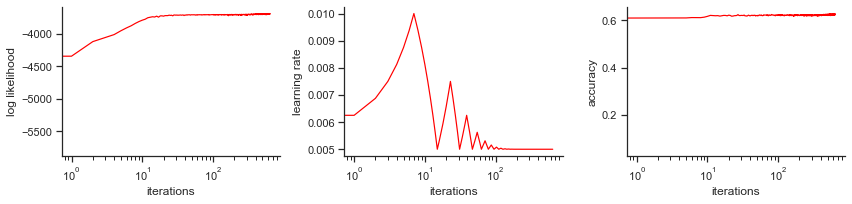

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 1.2})
log = model.tracker.get_data()
fig, axs = plt.subplots(1, 3, figsize=(12, 3), squeeze=False)
g1 = sns.lineplot(ax=axs[0, 0], data=log, x=log.index, y="full_ll", color='red') 
g2 = sns.lineplot(ax=axs[0, 1], data=log, x=log.index, y="lr", color='red')
g3 = sns.lineplot(ax=axs[0, 2],data=log, x=log.index, y="score", color='red') # y = score or full_ll or lr
g1.set(xscale="log", xlabel="iterations", ylabel="log likelihood")
g2.set(xscale="log", xlabel="iterations", ylabel="learning rate")
g3.set(xscale="log", xlabel="iterations", ylabel="accuracy")
sns.despine()
plt.tight_layout()
plt.show()

To generate the probability outputs, we call the `Predict` class on the model `model` and the database `db`. Two methods are used: `probs()` to generate the probabilities and `choices()` to generate a pseudo-choice output by selecting the choice with the highest probability. The code below concatenates the probabilities and choices together.

In [10]:
from pycmtensor.results import Predict

pd.concat((Predict(model, db).probs(), Predict(model, db).choices()), axis=1)

,0,1,2,3,CHOICE
0,0.500824,0.058328,0.079861,0.360987,0
1,0.799394,0.042385,0.022220,0.136001,0
2,0.426353,0.189620,0.080227,0.303800,0
3,0.790865,0.076560,0.028311,0.104264,0
4,0.400649,0.535800,0.035609,0.027942,1
...,...,...,...,...,...
3995,0.745616,0.068229,0.069323,0.116833,0
3996,0.328118,0.044203,0.031028,0.596651,3
3997,0.828171,0.047431,0.039376,0.085022,0
3998,0.666692,0.065301,0.030652,0.237355,0
